# Assignment&nbsp;7:&nbsp;Neural&nbsp;Networks&nbsp;using&nbsp;Keras&nbsp;and&nbsp;Tensorflow&nbsp;


Please see the associated document for questions. If you have problems with Keras and Tensorflow on your local installation please make sure they are updated. On Google Colab this notebook runs.

In [33]:
# imports
from __future__ import print_function
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
import tensorflow as tf
from matplotlib import pyplot as plt

In [34]:
# Hyper-parameters data-loading and formatting

batch_size = 128
num_classes = 10
epochs = 10

img_rows, img_cols = 28, 28

(x_train, lbl_train), (x_test, lbl_test) = mnist.load_data()


if K.image_data_format() == "channels_first":
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

## Preprocessing

In order to simplify vector operations we normalize the pixels by scaling them from the range [0,255] down to [0,1], dividing each pixel by its max value 255. However, we first need to cast the elements of the tensors to `float` as python's division assignment operator `/=`, doesn't work with `integers` when the ouput is `float`

In [35]:
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

x_train /= 255
x_test /= 255

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)


x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)


Next, we create a one-hot encoding of the digits 0-9, as classification models generally output a one-hot encoded vector with the same number of dimension as classes (10) in the dataset.

In [36]:
y_train = keras.utils.to_categorical(lbl_train, num_classes)
y_test = keras.utils.to_categorical(lbl_test, num_classes)

print('y_train shape, one-hot encoded:', y_train.shape)
print('y_test shape, one-hot encoded:', y_test.shape)  

y_train shape, one-hot encoded: (60000, 10)
y_test shape, one-hot encoded: (10000, 10)


### Question 2) Network model, training, and changing hyper-parameters.
#### Questions A-C
At this point, the dataset has been prepared and it's time to generate, tweak and fit a model for prediction. Here, a sequential model is used, appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor..

In [ ]:
## Define model ##
model = Sequential()

#### Layers used in the model
The first, so called, input layer flattens the input such that the number of dimensions correspond to the number of elements in the input tensor, since the next layer expects a vector as input. More specifically, each image is converted from a 28 x 28 matrix to a vector with 784 elements, 
Another reason for this is to couple information that exists vertically as well as horizontally. There is no way to *couple* the information *across rows* in the pixel arrays representing the images, without either flatting or using a 2-dimensional kernel like a convolution (or maybe some other operation we haven’t considered yet). Without doing this, you can infer information on a row-by-row basis (“horizontally”), but there’s no way to combine information that exists across rows -- it’s like you have a set of disconnected horizontal slices of an image, but no way to “see” the vertical structures, until you either flatten or switch to 2d convolution. 

In [ ]:
model.add(Flatten(input_shape=(28,28)))

The next two fully connected layers are what gives the network the complexity to, when correctly fitted, recognize the handwritten digits. These layers specify two arguments, the first one being the output format or the number neurons and the second one specfiying the **Rectified Linear Unit** as the activation function for the layers neurons. This activation function is what allows the layer to model nonlinear functions.

In [ ]:
model.add(Dense(64, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))

The final, so called, output layer should have it's output shape set to the expected output of the model. For the handwritten digit scenario, this might be to use one neuron per digit, in other words, a vector of 10 nodes. 
this layer specifies a different activation function,  **softmax**, which outputs a vector that represents the probability distributions of a list of potential outcomes (digits 0-9) which combined with the categorical cross-entropy loss function allows the neural network to output the digit with highest probability value.

In [ ]:
model.add(Dense(num_classes, activation='softmax'))

#### Model configuration
Below, the model is configured to use a loss function called **categorical cross-entropy**, suitable for classification tasks like this one since it compared to other common loss functions, such as the squared error cost function, does not suffer from the same learning slow downs as some of the others do. The mathematical representation for this cost function is 

$$  
loss_{CCE} = -\sum_{s\in S} t_s \cdot \log{p_s} 
$$ 

where $n$ is the set of output classes, $t_i$ the true value, taking either 0 or 1, and $p_i$ is the **softmax** probability of class $i$. The one-hot encoded format of the output imply that for a specific class, say 5, the cost function becomes

$$
loss_{CSE} = - (0 \cdot \log{p_1} + 0 \cdot \log{p_2} + \dots + 1 \cdot \log{p_5} + 0 \cdot \log{p_6} + \dots + 0  \cdot \log{p_9})
$$

Hence, the total loss turns into the negative sum of the logarithmic probability of each class

$$
loss_{CSE} = -\sum_{s\in S} \log{p_s} 
$$

This cost function has the important property of punishing the big mistakes more than small ones, which allows for improved learning as explained above.  

The optimizer is then set to use mini-batched gradient descent with a learning rate of 0.1. Lastly, the accuracy is specified as the evaluation metric used when training and testing the model.

In [ ]:
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.SGD(lr=0.1),
    metrics=["accuracy"],
)

As we can se from the summary below, our final model contains 4 layers, the first one with 784 neurons, the next two with 64 neurons each and the final output layer with 10 neurons. This results in a total of 55050 trainable parameters. 

In the first dense layer, each neuron is connevted to the 784 neurons in the input layer. That equals $784 \times 64 = $ trainable parameters plus 64 bias terms. In similar fashion, the second dense layer has each neuron connected with each of the preceding layers 64 neurons equaling another $64\times64=4096$ parameters plus 64 bias terms. The ten neurons in the output layer are indentically connected to 64 neurons each, adding another $64\times10=640$ parameters and 10 bias terms. Thus, we get a total of 

$$
(784\times64+64) + (64\times64+64) + (64\times10+10) = 55050
$$ 
parameters. 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


At this point the model is ready for training. Here, two hyperparameters `batch_size` and `epochs` can be used to tweak the training process. The prior refers to the number of training samples that are passed through the network at a time, while the latter refers to the number of times the neural network is exposed to the entire dataset. 

Tweaking these hyperparameters might both improve and worsen a model's performance. For instance, gradient descent typically doesn't reach a local or global minima after just one epoch. Hence, increasing the number of epochs might improve results up to a point were the model run the risk of overfitting, worsening it's performance on new data.

In [ ]:
fit_info = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y_test),
    # callbacks=[TqdmCallback()]
)

loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print("Test loss: {}, Test accuracy {}".format(loss, accuracy))

Epoch 1/10
469/469 [==============================] - 4s 7ms/step - loss: 0.8062 - accuracy: 0.7738 - val_loss: 0.2807 - val_accuracy: 0.9188
Epoch 2/10
469/469 [==============================] - 2s 3ms/step - loss: 0.2456 - accuracy: 0.9282 - val_loss: 0.1944 - val_accuracy: 0.9434
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1827 - accuracy: 0.9460 - val_loss: 0.1661 - val_accuracy: 0.9518
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1503 - accuracy: 0.9567 - val_loss: 0.1395 - val_accuracy: 0.9572
Epoch 5/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1286 - accuracy: 0.9624 - val_loss: 0.1286 - val_accuracy: 0.9596
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1125 - accuracy: 0.9667 - val_loss: 0.1096 - val_accuracy: 0.9657
Epoch 7/10
469/469 [==============================] - 2s 3ms/step - loss: 0.0968 - accuracy: 0.9715 - val_loss: 0.1044 - val_accuracy: 0.9672
Epoch 

#### 2.d) Improving the model

In [ ]:
from tensorflow.keras import regularizers
import numpy as np

epochs = 40
replicas = 3
regularization_factors = np.linspace(0.000001, 0.001, 5)
print('regularization_factors:', regularization_factors)

accuracies = {}
for l2_factor in regularization_factors:
    # regularizer, The L2 regularization penalty is computed as: loss = l2 * reduce_sum(square(x))
    regularizer = regularizers.l2(l2_factor)
    print('Training models with regulizer factor:',l2_factor)

    accuracies[l2_factor] = []
    for replica in range(replicas):
        # configure model
        model = Sequential()
        model.add(Flatten(input_shape=(28, 28)))
        model.add(Dense(500, activation='relu', kernel_regularizer=regularizer))
        model.add(Dense(300, activation='relu'))
        model.add(Dense(num_classes, activation='softmax'))
        model.compile(
            loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.SGD(learning_rate=0.1),
            metrics=["accuracy"],
        )
        fit = fit_info = model.fit(
            x_train,
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=0,
            validation_data=(x_test, y_test),
            # callbacks=[TqdmCallback()]
        )
        # collect accuracy of each replica for each l2 factor
        accuracies[l2_factor].append(np.max(fit.history.get('val_accuracy')))

regularization_factors: [1.0000e-06 2.5075e-04 5.0050e-04 7.5025e-04 1.0000e-03]
Training models with regulizer factor: 1e-06
Training models with regulizer factor: 0.00025075000000000005
Training models with regulizer factor: 0.0005005000000000001
Training models with regulizer factor: 0.0007502500000000002
Training models with regulizer factor: 0.001


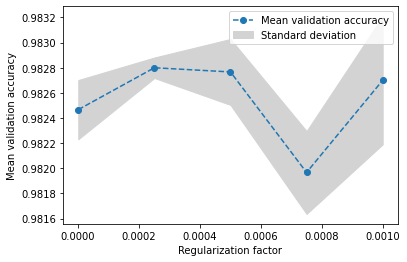

In [ ]:
# get mean validation accuracy and standard deviation from model training
validation_accuracies = np.array([np.mean(accs) for accs in accuracies.values()])
standard_deviations = np.array([np.std(accs) for accs in accuracies.values()])

# plot mean validation accuracy with standard deviation as a function of the regularization factor
plt.plot(regularization_factors, validation_accuracies, '--o', label='Mean validation accuracy')
plt.fill_between(
    regularization_factors,
    validation_accuracies - standard_deviations,
    validation_accuracies + standard_deviations, 
    color="lightgray", 
    label="Standard deviation"
)
plt.ylabel('Mean validation accuracy')
plt.xlabel('Regularization factor')
plt.legend(loc='best');

As theory suggests, the above graph show that reducing complexity, through regularization, correpsonds with improved valdiation accuracy and reduced variance up to certain factor. This behaviour suggests that the model is overfitting. The results obtained above are lower than those of Geoff Hinton's. The cause of this might be attributed to differences in important parameters such as size of training data, the preprocessing of this and hyper-parameter tweaking, such as using different batch sizes and learning rates.

## Question 3) 

We added two convolution layers (32 and 64) and two maxpooling to reduce the computational time

In [ ]:
model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))
model.add(Conv2D(64,kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizer))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.SGD(learning_rate=0.1),
    metrics=["accuracy"],
)

fit = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=40,
    verbose=0,
    validation_data=(x_test, y_test),
    # callbacks=[TqdmCallback()]
)
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print("Test loss: {}, Test accuracy {}".format(loss, accuracy))

Test loss: 0.06852845847606659, Test accuracy 0.9850000143051147


As seen the code did not reach an accuracy of 99%. This could be due to several factors, one is the fact that we recude the dense functions to 64 instead of 128 or like above 500 and 300, since the code took an unreasonably long time to run aswell as memory issues that occured whilst running the code. Also we could maybe getter a better score by using the best regulazing factor we achived above which is around 0.00002, but since the code took around 1h to run this was not viable to test.

The difference and perks of using convolutional layers it the pictures of hand drawn images is that it could potentially find patterns by transforming the picture before turning it into an one dimensional array. This could increase the accuracy of the model.

### Question 4) Auto-Encoder for denoising


#### 4.a) ####

The purpose of this model is to denoise the images. It firstly prepers the data by turning the traning and test data of 28x28 pixel pictures into a 1x784 vector/array. Then the salt_and_pepper method defined above it adds noice

In [19]:
import numpy as np
def salt_and_pepper(input, noise_level=0.5):
    """
    This applies salt and pepper noise to the input tensor - randomly setting bits to 1 or 0.
    Parameters
    ----------
    input : tensor
        The tensor to apply salt and pepper noise to.
    noise_level : float
        The amount of salt and pepper noise to add.
    Returns
    -------
    tensor
        Tensor with salt and pepper noise applied.
    """
    # salt and pepper noise
    a = np.random.binomial(size=input.shape, n=1, p=(1 - noise_level))
    b = np.random.binomial(size=input.shape, n=1, p=0.5)
    c = (a==0) * b
    return input * a + c


#data preparation
flattened_x_train = x_train.reshape(-1,784)
flattened_x_train_seasoned = salt_and_pepper(flattened_x_train, noise_level=0.4)

flattened_x_test = x_test.reshape(-1,784)
flattened_x_test_seasoneed = salt_and_pepper(flattened_x_test, noise_level=0.4)

The model is first encoded and later decoded. It consists of two layers enconded layers and two decoding layers. THe enconded layers consist of 128 and 96 neruons respectivly, The decoding layers first layer consist of 128 neurons and de second one 784 which is the same as the input_images.

The autoencoder makes use of a binary crossentropy function which solves the model through binary operations 0,1 or yes/no which is usefull when something can belong or not belong to several catergories simultaniously. Important to note is that the Dense block have to use sigmoid as an activation function.

In [20]:
latent_dim = 96  

input_image = keras.Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_image)
encoded = Dense(latent_dim, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(784, activation='sigmoid')(decoded)

autoencoder = keras.Model(input_image, decoded)

encoder = keras.Model(input_image, encoded)

encoded_input = keras.Input(shape=(latent_dim,))
decoder_layer = Sequential(autoencoder.layers[-2:])
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [31]:
fit_info_AE = autoencoder.fit(
    flattened_x_train_seasoned,
    flattened_x_train,
    epochs=40,
    batch_size=64,
    shuffle=True,
    validation_data=(flattened_x_test_seasoneed, flattened_x_test),
)


Epoch 1/5
938/938 [==============================] - 8s 8ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 2/5
938/938 [==============================] - 7s 8ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 3/5
938/938 [==============================] - 7s 8ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 4/5
938/938 [==============================] - 8s 9ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 5/5
938/938 [==============================] - 8s 8ms/step - loss: 0.0040 - val_loss: 0.0040


##### 4d) Explain how you can use the decoder part of the denoising auto-encoder to generate synthetic “hand-written” digits? – Describe the procedure and show examples in your report.

During the training process, the decoder is taught to reconstruct handwritten digits from it's noisy counterparts. If trained enough the decoder will be able to reconstruct images that to us are just noise. This can be utulized to generate handwritten digits by letting it decode images filled with ranomd noise. 

##### disclaimer
We had several problems with vizualizing the decoded pictures since we for some reason always got the same decoded picture, no matter the startning image chosen. We tried to find the problem but were not able to find the issue it within reasonable time.Therefor we could not complete 4b-d.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2206d3be-0005-47e9-b8a0-2566096b1bac' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>